<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:44] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


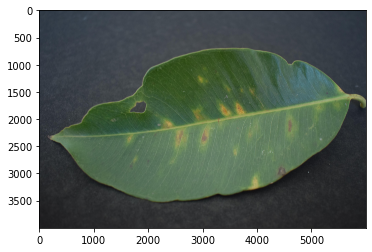

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

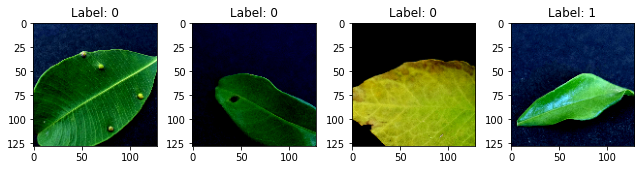

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:09:49] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:09:51] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2551469001218323 samples/sec                   batch loss = 0.5882571935653687 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2861169840074942 samples/sec                   batch loss = 0.7397372722625732 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.290307139443513 samples/sec                   batch loss = 0.38285520672798157 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2976625744839214 samples/sec                   batch loss = 0.7513723373413086 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2909969951252545 samples/sec                   batch loss = 0.701960027217865 | accuracy = 0.64


Epoch[1] Batch[30] Speed: 1.2855896352940195 samples/sec                   batch loss = 1.5225791931152344 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2855837246598174 samples/sec                   batch loss = 0.3464553654193878 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2960063788308345 samples/sec                   batch loss = 0.6502509713172913 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2994357205068021 samples/sec                   batch loss = 0.7397822141647339 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2924266100718926 samples/sec                   batch loss = 0.4745980203151703 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2912516575287885 samples/sec                   batch loss = 1.2285794019699097 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2984118670081792 samples/sec                   batch loss = 0.5711271166801453 | accuracy = 0.575


Epoch[1] Batch[65] Speed: 1.3011421705008646 samples/sec                   batch loss = 0.6544594168663025 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.2985242199473723 samples/sec                   batch loss = 1.0334770679473877 | accuracy = 0.575


Epoch[1] Batch[75] Speed: 1.2855941668170479 samples/sec                   batch loss = 0.6307044625282288 | accuracy = 0.5666666666666667


Epoch[1] Batch[80] Speed: 1.2902138649794002 samples/sec                   batch loss = 1.4494619369506836 | accuracy = 0.559375


Epoch[1] Batch[85] Speed: 1.2932675563994451 samples/sec                   batch loss = 0.6223489046096802 | accuracy = 0.5676470588235294


Epoch[1] Batch[90] Speed: 1.2926837292763553 samples/sec                   batch loss = 0.5599501132965088 | accuracy = 0.5777777777777777


Epoch[1] Batch[95] Speed: 1.291251955670845 samples/sec                   batch loss = 0.7800012230873108 | accuracy = 0.5868421052631579


Epoch[1] Batch[100] Speed: 1.2927463814817177 samples/sec                   batch loss = 0.5323447585105896 | accuracy = 0.5975


Epoch[1] Batch[105] Speed: 1.2944321002065957 samples/sec                   batch loss = 1.138688087463379 | accuracy = 0.5952380952380952


Epoch[1] Batch[110] Speed: 1.2851552499949825 samples/sec                   batch loss = 0.4830974340438843 | accuracy = 0.6045454545454545


Epoch[1] Batch[115] Speed: 1.2934883104146941 samples/sec                   batch loss = 0.6326020359992981 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2912384400359576 samples/sec                   batch loss = 0.46673107147216797 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.294625079413118 samples/sec                   batch loss = 0.8117215633392334 | accuracy = 0.616


Epoch[1] Batch[130] Speed: 1.2934355579105437 samples/sec                   batch loss = 0.9126854538917542 | accuracy = 0.6153846153846154


Epoch[1] Batch[135] Speed: 1.2898830478551444 samples/sec                   batch loss = 0.6242685317993164 | accuracy = 0.6185185185185185


Epoch[1] Batch[140] Speed: 1.2922224414794905 samples/sec                   batch loss = 0.40538811683654785 | accuracy = 0.6214285714285714


Epoch[1] Batch[145] Speed: 1.2956334617726635 samples/sec                   batch loss = 0.3760429918766022 | accuracy = 0.6172413793103448


Epoch[1] Batch[150] Speed: 1.2969530460649341 samples/sec                   batch loss = 0.5487358570098877 | accuracy = 0.6216666666666667


Epoch[1] Batch[155] Speed: 1.3034324885901598 samples/sec                   batch loss = 0.3952949643135071 | accuracy = 0.6258064516129033


Epoch[1] Batch[160] Speed: 1.2852275122936554 samples/sec                   batch loss = 0.2715352773666382 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2913548228983966 samples/sec                   batch loss = 0.7177113890647888 | accuracy = 0.6257575757575757


Epoch[1] Batch[170] Speed: 1.2916217577839668 samples/sec                   batch loss = 0.6196927428245544 | accuracy = 0.6279411764705882


Epoch[1] Batch[175] Speed: 1.2960841720008325 samples/sec                   batch loss = 0.6654216051101685 | accuracy = 0.63


Epoch[1] Batch[180] Speed: 1.3006414513287892 samples/sec                   batch loss = 0.8300397396087646 | accuracy = 0.6305555555555555


Epoch[1] Batch[185] Speed: 1.293954694044237 samples/sec                   batch loss = 0.5670304298400879 | accuracy = 0.6297297297297297


Epoch[1] Batch[190] Speed: 1.2900931243466283 samples/sec                   batch loss = 0.38212141394615173 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2997706508019784 samples/sec                   batch loss = 0.6137738823890686 | accuracy = 0.6256410256410256


Epoch[1] Batch[200] Speed: 1.2951941635258657 samples/sec                   batch loss = 1.0126996040344238 | accuracy = 0.6225


Epoch[1] Batch[205] Speed: 1.3018495228139266 samples/sec                   batch loss = 0.5170414447784424 | accuracy = 0.6280487804878049


Epoch[1] Batch[210] Speed: 1.2902983075598724 samples/sec                   batch loss = 0.8354336023330688 | accuracy = 0.625


Epoch[1] Batch[215] Speed: 1.2946137907427315 samples/sec                   batch loss = 0.6834065914154053 | accuracy = 0.627906976744186


Epoch[1] Batch[220] Speed: 1.2901066160155559 samples/sec                   batch loss = 0.5060668587684631 | accuracy = 0.6261363636363636


Epoch[1] Batch[225] Speed: 1.2907021176797142 samples/sec                   batch loss = 0.7455819845199585 | accuracy = 0.6244444444444445


Epoch[1] Batch[230] Speed: 1.2926167011293244 samples/sec                   batch loss = 0.6476117968559265 | accuracy = 0.6228260869565218


Epoch[1] Batch[235] Speed: 1.294645259650701 samples/sec                   batch loss = 1.061525821685791 | accuracy = 0.624468085106383


Epoch[1] Batch[240] Speed: 1.2880038385505632 samples/sec                   batch loss = 0.3385854959487915 | accuracy = 0.628125


Epoch[1] Batch[245] Speed: 1.3017817428101286 samples/sec                   batch loss = 0.3893168270587921 | accuracy = 0.6306122448979592


Epoch[1] Batch[250] Speed: 1.2994035150902588 samples/sec                   batch loss = 0.7104812264442444 | accuracy = 0.633


Epoch[1] Batch[255] Speed: 1.2981916393108754 samples/sec                   batch loss = 0.4226989150047302 | accuracy = 0.6303921568627451


Epoch[1] Batch[260] Speed: 1.2945550528741423 samples/sec                   batch loss = 0.5078607797622681 | accuracy = 0.6326923076923077


Epoch[1] Batch[265] Speed: 1.285095890725744 samples/sec                   batch loss = 0.9376097917556763 | accuracy = 0.6311320754716981


Epoch[1] Batch[270] Speed: 1.2917086721294941 samples/sec                   batch loss = 0.5476557016372681 | accuracy = 0.6314814814814815


Epoch[1] Batch[275] Speed: 1.2951124781095076 samples/sec                   batch loss = 0.4589936435222626 | accuracy = 0.63


Epoch[1] Batch[280] Speed: 1.305397445882764 samples/sec                   batch loss = 0.5171598196029663 | accuracy = 0.6339285714285714


Epoch[1] Batch[285] Speed: 1.2968818652224932 samples/sec                   batch loss = 0.17677155137062073 | accuracy = 0.637719298245614


Epoch[1] Batch[290] Speed: 1.2946212832011066 samples/sec                   batch loss = 0.5137706995010376 | accuracy = 0.6396551724137931


Epoch[1] Batch[295] Speed: 1.2930155861207273 samples/sec                   batch loss = 0.782662570476532 | accuracy = 0.6406779661016949


Epoch[1] Batch[300] Speed: 1.2916676996077083 samples/sec                   batch loss = 0.5600646138191223 | accuracy = 0.6425


Epoch[1] Batch[305] Speed: 1.291106478705367 samples/sec                   batch loss = 0.26444709300994873 | accuracy = 0.6442622950819672


Epoch[1] Batch[310] Speed: 1.2965434120067014 samples/sec                   batch loss = 0.4644051194190979 | accuracy = 0.646774193548387


Epoch[1] Batch[315] Speed: 1.2871557974739327 samples/sec                   batch loss = 0.7420403957366943 | accuracy = 0.6452380952380953


Epoch[1] Batch[320] Speed: 1.29877602947209 samples/sec                   batch loss = 0.4453426003456116 | accuracy = 0.64609375


Epoch[1] Batch[325] Speed: 1.2947429728666207 samples/sec                   batch loss = 0.7092854380607605 | accuracy = 0.6461538461538462


Epoch[1] Batch[330] Speed: 1.2952119617155806 samples/sec                   batch loss = 0.45222538709640503 | accuracy = 0.6484848484848484


Epoch[1] Batch[335] Speed: 1.2888483442886978 samples/sec                   batch loss = 0.621922492980957 | accuracy = 0.6507462686567164


Epoch[1] Batch[340] Speed: 1.283322174430894 samples/sec                   batch loss = 0.3446151912212372 | accuracy = 0.6529411764705882


Epoch[1] Batch[345] Speed: 1.2842968957343015 samples/sec                   batch loss = 0.9038366675376892 | accuracy = 0.6543478260869565


Epoch[1] Batch[350] Speed: 1.290444098730586 samples/sec                   batch loss = 0.7378957271575928 | accuracy = 0.6542857142857142


Epoch[1] Batch[355] Speed: 1.2969745021048797 samples/sec                   batch loss = 0.28554728627204895 | accuracy = 0.6556338028169014


Epoch[1] Batch[360] Speed: 1.2957184151367496 samples/sec                   batch loss = 0.7205740213394165 | accuracy = 0.6541666666666667


Epoch[1] Batch[365] Speed: 1.285990207376186 samples/sec                   batch loss = 0.918387770652771 | accuracy = 0.6547945205479452


Epoch[1] Batch[370] Speed: 1.2959359024775408 samples/sec                   batch loss = 0.5056557059288025 | accuracy = 0.6560810810810811


Epoch[1] Batch[375] Speed: 1.3006184622030117 samples/sec                   batch loss = 0.5055625438690186 | accuracy = 0.6566666666666666


Epoch[1] Batch[380] Speed: 1.2995485526993964 samples/sec                   batch loss = 0.4571152627468109 | accuracy = 0.655921052631579


Epoch[1] Batch[385] Speed: 1.2977460876479787 samples/sec                   batch loss = 0.5856635570526123 | accuracy = 0.6558441558441559


Epoch[1] Batch[390] Speed: 1.2991245018680142 samples/sec                   batch loss = 0.237926185131073 | accuracy = 0.6602564102564102


Epoch[1] Batch[395] Speed: 1.2915888447638282 samples/sec                   batch loss = 0.4575132131576538 | accuracy = 0.6620253164556962


Epoch[1] Batch[400] Speed: 1.2947014079783354 samples/sec                   batch loss = 0.2714059352874756 | accuracy = 0.66375


Epoch[1] Batch[405] Speed: 1.304344506713863 samples/sec                   batch loss = 0.48507779836654663 | accuracy = 0.6623456790123456


Epoch[1] Batch[410] Speed: 1.298474573227853 samples/sec                   batch loss = 0.4862099587917328 | accuracy = 0.6603658536585366


Epoch[1] Batch[415] Speed: 1.2969121411892972 samples/sec                   batch loss = 0.3315504193305969 | accuracy = 0.6614457831325301


Epoch[1] Batch[420] Speed: 1.2915433062513293 samples/sec                   batch loss = 0.7749250531196594 | accuracy = 0.6613095238095238


Epoch[1] Batch[425] Speed: 1.2918852218226227 samples/sec                   batch loss = 0.5309184789657593 | accuracy = 0.6629411764705883


Epoch[1] Batch[430] Speed: 1.2902101938135768 samples/sec                   batch loss = 0.9886353611946106 | accuracy = 0.6622093023255814


Epoch[1] Batch[435] Speed: 1.288170277379562 samples/sec                   batch loss = 0.6123560070991516 | accuracy = 0.6626436781609195


Epoch[1] Batch[440] Speed: 1.2918973582783282 samples/sec                   batch loss = 0.9200621843338013 | accuracy = 0.6647727272727273


Epoch[1] Batch[445] Speed: 1.2826621659517328 samples/sec                   batch loss = 0.9531705975532532 | accuracy = 0.6646067415730337


Epoch[1] Batch[450] Speed: 1.287150366181394 samples/sec                   batch loss = 1.08408784866333 | accuracy = 0.6633333333333333


Epoch[1] Batch[455] Speed: 1.2920295808354827 samples/sec                   batch loss = 0.3276124596595764 | accuracy = 0.6648351648351648


Epoch[1] Batch[460] Speed: 1.2943796701453556 samples/sec                   batch loss = 1.3882008790969849 | accuracy = 0.6668478260869565


Epoch[1] Batch[465] Speed: 1.2919474981843893 samples/sec                   batch loss = 0.7215723991394043 | accuracy = 0.6661290322580645


Epoch[1] Batch[470] Speed: 1.2834735609150956 samples/sec                   batch loss = 0.7239062190055847 | accuracy = 0.6675531914893617


Epoch[1] Batch[475] Speed: 1.2820698455812336 samples/sec                   batch loss = 1.2042980194091797 | accuracy = 0.6657894736842105


Epoch[1] Batch[480] Speed: 1.2950253050414176 samples/sec                   batch loss = 0.6767377853393555 | accuracy = 0.6671875


Epoch[1] Batch[485] Speed: 1.2950460975515246 samples/sec                   batch loss = 1.3761725425720215 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.291921233938689 samples/sec                   batch loss = 0.23662671446800232 | accuracy = 0.6678571428571428


Epoch[1] Batch[495] Speed: 1.2852770373355265 samples/sec                   batch loss = 0.4507880210876465 | accuracy = 0.6696969696969697


Epoch[1] Batch[500] Speed: 1.2883872167707966 samples/sec                   batch loss = 0.536708652973175 | accuracy = 0.67


Epoch[1] Batch[505] Speed: 1.287274112274147 samples/sec                   batch loss = 0.32289737462997437 | accuracy = 0.6717821782178218


Epoch[1] Batch[510] Speed: 1.2847729070405982 samples/sec                   batch loss = 0.3766798675060272 | accuracy = 0.6735294117647059


Epoch[1] Batch[515] Speed: 1.2913124813592587 samples/sec                   batch loss = 0.23028485476970673 | accuracy = 0.675242718446602


Epoch[1] Batch[520] Speed: 1.2851493433543613 samples/sec                   batch loss = 0.13628238439559937 | accuracy = 0.6764423076923077


Epoch[1] Batch[525] Speed: 1.290714728406406 samples/sec                   batch loss = 0.6154390573501587 | accuracy = 0.6776190476190476


Epoch[1] Batch[530] Speed: 1.2941260684868277 samples/sec                   batch loss = 0.22441759705543518 | accuracy = 0.6783018867924528


Epoch[1] Batch[535] Speed: 1.301577839279821 samples/sec                   batch loss = 1.4241085052490234 | accuracy = 0.6771028037383178


Epoch[1] Batch[540] Speed: 1.2940171700917662 samples/sec                   batch loss = 0.4865991175174713 | accuracy = 0.6754629629629629


Epoch[1] Batch[545] Speed: 1.2914900163495282 samples/sec                   batch loss = 0.38112035393714905 | accuracy = 0.676605504587156


Epoch[1] Batch[550] Speed: 1.2862932904150188 samples/sec                   batch loss = 0.7707983255386353 | accuracy = 0.6781818181818182


Epoch[1] Batch[555] Speed: 1.2980257141486617 samples/sec                   batch loss = 0.29094964265823364 | accuracy = 0.6779279279279279


Epoch[1] Batch[560] Speed: 1.289020349463923 samples/sec                   batch loss = 0.5040932297706604 | accuracy = 0.678125


Epoch[1] Batch[565] Speed: 1.2890781899568295 samples/sec                   batch loss = 0.28395581245422363 | accuracy = 0.6787610619469027


Epoch[1] Batch[570] Speed: 1.2856252972735547 samples/sec                   batch loss = 0.3966681957244873 | accuracy = 0.6793859649122806


Epoch[1] Batch[575] Speed: 1.2756210864894482 samples/sec                   batch loss = 0.6218538284301758 | accuracy = 0.6804347826086956


Epoch[1] Batch[580] Speed: 1.2908333011469086 samples/sec                   batch loss = 0.5508826971054077 | accuracy = 0.6797413793103448


Epoch[1] Batch[585] Speed: 1.2933831088360512 samples/sec                   batch loss = 0.3467090129852295 | accuracy = 0.6807692307692308


Epoch[1] Batch[590] Speed: 1.294179076995374 samples/sec                   batch loss = 0.9396349191665649 | accuracy = 0.6805084745762712


Epoch[1] Batch[595] Speed: 1.2871453299329054 samples/sec                   batch loss = 0.37817445397377014 | accuracy = 0.6815126050420168


Epoch[1] Batch[600] Speed: 1.279440869346648 samples/sec                   batch loss = 0.6599562168121338 | accuracy = 0.68125


Epoch[1] Batch[605] Speed: 1.2884552912461276 samples/sec                   batch loss = 0.31603190302848816 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2830663123449626 samples/sec                   batch loss = 0.7726462483406067 | accuracy = 0.6799180327868852


Epoch[1] Batch[615] Speed: 1.2965608464995124 samples/sec                   batch loss = 0.7214254140853882 | accuracy = 0.6800813008130081


Epoch[1] Batch[620] Speed: 1.2907108557948264 samples/sec                   batch loss = 0.42256277799606323 | accuracy = 0.6810483870967742


Epoch[1] Batch[625] Speed: 1.2814623132185983 samples/sec                   batch loss = 0.716206431388855 | accuracy = 0.6804


Epoch[1] Batch[630] Speed: 1.2837900956375725 samples/sec                   batch loss = 0.45490342378616333 | accuracy = 0.6813492063492064


Epoch[1] Batch[635] Speed: 1.2824736187404921 samples/sec                   batch loss = 1.0684757232666016 | accuracy = 0.681496062992126


Epoch[1] Batch[640] Speed: 1.2851239454183627 samples/sec                   batch loss = 0.40553009510040283 | accuracy = 0.682421875


Epoch[1] Batch[645] Speed: 1.2852117596013128 samples/sec                   batch loss = 0.33298221230506897 | accuracy = 0.6837209302325581


Epoch[1] Batch[650] Speed: 1.2804645239876984 samples/sec                   batch loss = 0.4617966115474701 | accuracy = 0.6846153846153846


Epoch[1] Batch[655] Speed: 1.2906275506239966 samples/sec                   batch loss = 0.4019598662853241 | accuracy = 0.6854961832061068


Epoch[1] Batch[660] Speed: 1.2913302724189197 samples/sec                   batch loss = 0.5261107683181763 | accuracy = 0.6859848484848485


Epoch[1] Batch[665] Speed: 1.2977228996218808 samples/sec                   batch loss = 0.5532931089401245 | accuracy = 0.6860902255639098


Epoch[1] Batch[670] Speed: 1.3012824490383494 samples/sec                   batch loss = 0.7006787061691284 | accuracy = 0.6861940298507463


Epoch[1] Batch[675] Speed: 1.2892070621849017 samples/sec                   batch loss = 0.3253231644630432 | accuracy = 0.6874074074074074


Epoch[1] Batch[680] Speed: 1.2900836009855168 samples/sec                   batch loss = 0.1571260541677475 | accuracy = 0.6882352941176471


Epoch[1] Batch[685] Speed: 1.2969842277399841 samples/sec                   batch loss = 0.6616913676261902 | accuracy = 0.6886861313868613


Epoch[1] Batch[690] Speed: 1.2936954729260868 samples/sec                   batch loss = 0.8621860146522522 | accuracy = 0.6880434782608695


Epoch[1] Batch[695] Speed: 1.3000864104244867 samples/sec                   batch loss = 0.44660133123397827 | accuracy = 0.6881294964028777


Epoch[1] Batch[700] Speed: 1.2860276659875702 samples/sec                   batch loss = 0.44163572788238525 | accuracy = 0.6875


Epoch[1] Batch[705] Speed: 1.284144233786711 samples/sec                   batch loss = 0.7845655083656311 | accuracy = 0.6886524822695036


Epoch[1] Batch[710] Speed: 1.2918014665996584 samples/sec                   batch loss = 0.3101409673690796 | accuracy = 0.6901408450704225


Epoch[1] Batch[715] Speed: 1.2915220295318026 samples/sec                   batch loss = 0.377893328666687 | accuracy = 0.6898601398601398


Epoch[1] Batch[720] Speed: 1.2923761343098683 samples/sec                   batch loss = 0.27537181973457336 | accuracy = 0.6895833333333333


Epoch[1] Batch[725] Speed: 1.289066007366721 samples/sec                   batch loss = 0.3833802044391632 | accuracy = 0.69


Epoch[1] Batch[730] Speed: 1.2863523658435023 samples/sec                   batch loss = 1.7182012796401978 | accuracy = 0.6893835616438356


Epoch[1] Batch[735] Speed: 1.2935203230112353 samples/sec                   batch loss = 0.32360994815826416 | accuracy = 0.689795918367347


Epoch[1] Batch[740] Speed: 1.2970801884742955 samples/sec                   batch loss = 0.6338253617286682 | accuracy = 0.6905405405405406


Epoch[1] Batch[745] Speed: 1.2967681925879642 samples/sec                   batch loss = 0.5258403420448303 | accuracy = 0.6909395973154362


Epoch[1] Batch[750] Speed: 1.2906569395399976 samples/sec                   batch loss = 0.4711938500404358 | accuracy = 0.6926666666666667


Epoch[1] Batch[755] Speed: 1.290197890599364 samples/sec                   batch loss = 0.5654228329658508 | accuracy = 0.6933774834437086


Epoch[1] Batch[760] Speed: 1.2874721752812055 samples/sec                   batch loss = 0.5677573680877686 | accuracy = 0.6944078947368421


Epoch[1] Batch[765] Speed: 1.2972350390758318 samples/sec                   batch loss = 0.38935887813568115 | accuracy = 0.6944444444444444


Epoch[1] Batch[770] Speed: 1.2927106221658993 samples/sec                   batch loss = 0.5745948553085327 | accuracy = 0.6944805194805195


Epoch[1] Batch[775] Speed: 1.2968268307442865 samples/sec                   batch loss = 0.2663378119468689 | accuracy = 0.6958064516129032


Epoch[1] Batch[780] Speed: 1.2839986833385617 samples/sec                   batch loss = 1.2556158304214478 | accuracy = 0.694551282051282


Epoch[1] Batch[785] Speed: 1.2903638053036293 samples/sec                   batch loss = 0.541225016117096 | accuracy = 0.6952229299363057


[Epoch 1] training: accuracy=0.6954314720812182
[Epoch 1] time cost: 637.2049520015717
[Epoch 1] validation: validation accuracy=0.7188888888888889


Epoch[2] Batch[5] Speed: 1.299369600486748 samples/sec                   batch loss = 0.6390455961227417 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2908674668500546 samples/sec                   batch loss = 0.6422151923179626 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.288656093478249 samples/sec                   batch loss = 0.1952212005853653 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2921223219055236 samples/sec                   batch loss = 1.1396852731704712 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2910688230016452 samples/sec                   batch loss = 0.2541610598564148 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.3001013208912053 samples/sec                   batch loss = 0.23887735605239868 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.28901212940418 samples/sec                   batch loss = 0.5265475511550903 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2825030296326472 samples/sec                   batch loss = 0.4293747842311859 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2949586335626078 samples/sec                   batch loss = 0.3714570999145508 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2854815777851538 samples/sec                   batch loss = 0.18512243032455444 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.284707286999928 samples/sec                   batch loss = 0.3179364502429962 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2883471472236159 samples/sec                   batch loss = 0.43027833104133606 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2852602003622615 samples/sec                   batch loss = 0.2555794417858124 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.294402938581653 samples/sec                   batch loss = 0.20501799881458282 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2965320898573192 samples/sec                   batch loss = 0.36038142442703247 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.29702704232164 samples/sec                   batch loss = 0.32941797375679016 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2987728121278133 samples/sec                   batch loss = 0.6422126293182373 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2913538289337274 samples/sec                   batch loss = 0.2866140305995941 | accuracy = 0.75


Epoch[2] Batch[95] Speed: 1.2964025504886927 samples/sec                   batch loss = 0.5764596462249756 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.3003650307147894 samples/sec                   batch loss = 0.4103381037712097 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2991584036780182 samples/sec                   batch loss = 1.7852294445037842 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2975698392873287 samples/sec                   batch loss = 0.46354472637176514 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.285017147255769 samples/sec                   batch loss = 0.47722023725509644 | accuracy = 0.75


Epoch[2] Batch[120] Speed: 1.2914892210111668 samples/sec                   batch loss = 0.5873527526855469 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2981278555524254 samples/sec                   batch loss = 0.29954177141189575 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2966214700810206 samples/sec                   batch loss = 0.42292848229408264 | accuracy = 0.7576923076923077


Epoch[2] Batch[135] Speed: 1.2927995758790454 samples/sec                   batch loss = 0.29794561862945557 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2901856868364303 samples/sec                   batch loss = 0.321740984916687 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.2901075088565428 samples/sec                   batch loss = 0.8626970648765564 | accuracy = 0.7603448275862069


Epoch[2] Batch[150] Speed: 1.2948119205131392 samples/sec                   batch loss = 0.5841034650802612 | accuracy = 0.7616666666666667


Epoch[2] Batch[155] Speed: 1.2914504494539176 samples/sec                   batch loss = 0.296935111284256 | accuracy = 0.7645161290322581


Epoch[2] Batch[160] Speed: 1.2869856716621708 samples/sec                   batch loss = 0.41254162788391113 | accuracy = 0.7671875


Epoch[2] Batch[165] Speed: 1.2951020807051958 samples/sec                   batch loss = 0.5803120732307434 | accuracy = 0.7666666666666667


Epoch[2] Batch[170] Speed: 1.2882289318502882 samples/sec                   batch loss = 0.8437369465827942 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2943591986077851 samples/sec                   batch loss = 0.6779253482818604 | accuracy = 0.7585714285714286


Epoch[2] Batch[180] Speed: 1.2895939326451231 samples/sec                   batch loss = 0.18095098435878754 | accuracy = 0.7569444444444444


Epoch[2] Batch[185] Speed: 1.2993485682837722 samples/sec                   batch loss = 0.3396404981613159 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2876309660477183 samples/sec                   batch loss = 0.20169126987457275 | accuracy = 0.7592105263157894


Epoch[2] Batch[195] Speed: 1.286531104519932 samples/sec                   batch loss = 0.3009944260120392 | accuracy = 0.7589743589743589


Epoch[2] Batch[200] Speed: 1.2920390334467995 samples/sec                   batch loss = 0.6208602786064148 | accuracy = 0.75625


Epoch[2] Batch[205] Speed: 1.300217896261044 samples/sec                   batch loss = 0.5883984565734863 | accuracy = 0.7573170731707317


Epoch[2] Batch[210] Speed: 1.2866558169829478 samples/sec                   batch loss = 0.671297013759613 | accuracy = 0.7559523809523809


Epoch[2] Batch[215] Speed: 1.2636296562085845 samples/sec                   batch loss = 0.4369552731513977 | accuracy = 0.7558139534883721


Epoch[2] Batch[220] Speed: 1.2613674228708975 samples/sec                   batch loss = 0.7155600190162659 | accuracy = 0.7522727272727273


Epoch[2] Batch[225] Speed: 1.2684970835603473 samples/sec                   batch loss = 0.35289686918258667 | accuracy = 0.7533333333333333


Epoch[2] Batch[230] Speed: 1.2660663349243793 samples/sec                   batch loss = 0.2585318088531494 | accuracy = 0.7521739130434782


Epoch[2] Batch[235] Speed: 1.264350917861581 samples/sec                   batch loss = 0.4029204845428467 | accuracy = 0.7553191489361702


Epoch[2] Batch[240] Speed: 1.2640830388716542 samples/sec                   batch loss = 0.600055456161499 | accuracy = 0.7583333333333333


Epoch[2] Batch[245] Speed: 1.2615173729917548 samples/sec                   batch loss = 0.6208500266075134 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2704741578417924 samples/sec                   batch loss = 0.6880329251289368 | accuracy = 0.755


Epoch[2] Batch[255] Speed: 1.2656834240380945 samples/sec                   batch loss = 0.35141217708587646 | accuracy = 0.7558823529411764


Epoch[2] Batch[260] Speed: 1.2653680237464064 samples/sec                   batch loss = 0.777456521987915 | accuracy = 0.7557692307692307


Epoch[2] Batch[265] Speed: 1.2680365043486963 samples/sec                   batch loss = 0.6466770768165588 | accuracy = 0.7528301886792453


Epoch[2] Batch[270] Speed: 1.2583639019744366 samples/sec                   batch loss = 0.635257363319397 | accuracy = 0.7481481481481481


Epoch[2] Batch[275] Speed: 1.2680220327801053 samples/sec                   batch loss = 0.5753620862960815 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.263437052772236 samples/sec                   batch loss = 0.3484547734260559 | accuracy = 0.7482142857142857


Epoch[2] Batch[285] Speed: 1.2672988752631233 samples/sec                   batch loss = 1.0949816703796387 | accuracy = 0.7491228070175439


Epoch[2] Batch[290] Speed: 1.2698507465849689 samples/sec                   batch loss = 0.25846683979034424 | accuracy = 0.7482758620689656


Epoch[2] Batch[295] Speed: 1.269487636634443 samples/sec                   batch loss = 0.3152945637702942 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2661997252086878 samples/sec                   batch loss = 0.4134864807128906 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.2733057025176626 samples/sec                   batch loss = 0.7639856338500977 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.2624173479810086 samples/sec                   batch loss = 1.05134916305542 | accuracy = 0.7451612903225806


Epoch[2] Batch[315] Speed: 1.2660359533885628 samples/sec                   batch loss = 0.42057210206985474 | accuracy = 0.7436507936507937


Epoch[2] Batch[320] Speed: 1.2624449911933988 samples/sec                   batch loss = 0.6440256834030151 | accuracy = 0.7421875


Epoch[2] Batch[325] Speed: 1.2640958967555038 samples/sec                   batch loss = 0.4355764389038086 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.26613312210507 samples/sec                   batch loss = 0.7876730561256409 | accuracy = 0.7393939393939394


Epoch[2] Batch[335] Speed: 1.2684617900557567 samples/sec                   batch loss = 0.19904017448425293 | accuracy = 0.7417910447761195


Epoch[2] Batch[340] Speed: 1.2659387995852345 samples/sec                   batch loss = 0.2964726686477661 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.2608749534327004 samples/sec                   batch loss = 0.48741668462753296 | accuracy = 0.741304347826087


Epoch[2] Batch[350] Speed: 1.2645032937184684 samples/sec                   batch loss = 0.07522529363632202 | accuracy = 0.7421428571428571


Epoch[2] Batch[355] Speed: 1.264596605132853 samples/sec                   batch loss = 0.6622227430343628 | accuracy = 0.7429577464788732


Epoch[2] Batch[360] Speed: 1.2662784730676067 samples/sec                   batch loss = 0.3268747925758362 | accuracy = 0.7430555555555556


Epoch[2] Batch[365] Speed: 1.2720645424364578 samples/sec                   batch loss = 0.5704311728477478 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2661079924820853 samples/sec                   batch loss = 0.2751777172088623 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.2685399563014519 samples/sec                   batch loss = 0.4670525789260864 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.275081375927105 samples/sec                   batch loss = 0.2618025541305542 | accuracy = 0.7440789473684211


Epoch[2] Batch[385] Speed: 1.270140787960156 samples/sec                   batch loss = 0.6876524686813354 | accuracy = 0.7422077922077922


Epoch[2] Batch[390] Speed: 1.2565658408580638 samples/sec                   batch loss = 0.55157870054245 | accuracy = 0.742948717948718


Epoch[2] Batch[395] Speed: 1.257435295230419 samples/sec                   batch loss = 0.6540505886077881 | accuracy = 0.7424050632911392


Epoch[2] Batch[400] Speed: 1.2644984331334874 samples/sec                   batch loss = 0.45774906873703003 | accuracy = 0.74375


Epoch[2] Batch[405] Speed: 1.2593832111824164 samples/sec                   batch loss = 0.25238412618637085 | accuracy = 0.7444444444444445


Epoch[2] Batch[410] Speed: 1.2548112945773136 samples/sec                   batch loss = 1.2498973608016968 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.2574934461577576 samples/sec                   batch loss = 0.3635057806968689 | accuracy = 0.7427710843373494


Epoch[2] Batch[420] Speed: 1.258435164982874 samples/sec                   batch loss = 0.26437970995903015 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2558304003305523 samples/sec                   batch loss = 0.3922266960144043 | accuracy = 0.7447058823529412


Epoch[2] Batch[430] Speed: 1.2713217392991203 samples/sec                   batch loss = 0.3904065787792206 | accuracy = 0.7436046511627907


Epoch[2] Batch[435] Speed: 1.264509107408404 samples/sec                   batch loss = 0.36010870337486267 | accuracy = 0.7442528735632183


Epoch[2] Batch[440] Speed: 1.263561039259361 samples/sec                   batch loss = 0.3407820165157318 | accuracy = 0.74375


Epoch[2] Batch[445] Speed: 1.2629890773214587 samples/sec                   batch loss = 0.4279721677303314 | accuracy = 0.744943820224719


Epoch[2] Batch[450] Speed: 1.2609894336654215 samples/sec                   batch loss = 0.17393721640110016 | accuracy = 0.745


Epoch[2] Batch[455] Speed: 1.2641652385935176 samples/sec                   batch loss = 0.30823591351509094 | accuracy = 0.7456043956043956


Epoch[2] Batch[460] Speed: 1.2649338419542928 samples/sec                   batch loss = 0.36061370372772217 | accuracy = 0.746195652173913


Epoch[2] Batch[465] Speed: 1.2629659738296826 samples/sec                   batch loss = 0.40374380350112915 | accuracy = 0.7451612903225806


Epoch[2] Batch[470] Speed: 1.2585137052230835 samples/sec                   batch loss = 0.6644799113273621 | accuracy = 0.7441489361702127


Epoch[2] Batch[475] Speed: 1.256989398928999 samples/sec                   batch loss = 0.6744440793991089 | accuracy = 0.7436842105263158


Epoch[2] Batch[480] Speed: 1.2624394814530937 samples/sec                   batch loss = 0.47885555028915405 | accuracy = 0.7432291666666667


Epoch[2] Batch[485] Speed: 1.2595305150502838 samples/sec                   batch loss = 0.5350216031074524 | accuracy = 0.7438144329896907


Epoch[2] Batch[490] Speed: 1.2691867558129586 samples/sec                   batch loss = 0.28171682357788086 | accuracy = 0.7443877551020408


Epoch[2] Batch[495] Speed: 1.2609015814990985 samples/sec                   batch loss = 0.6535652279853821 | accuracy = 0.7439393939393939


Epoch[2] Batch[500] Speed: 1.2549269291420095 samples/sec                   batch loss = 0.631563127040863 | accuracy = 0.742


Epoch[2] Batch[505] Speed: 1.2630722759091921 samples/sec                   batch loss = 0.4620571434497833 | accuracy = 0.7420792079207921


Epoch[2] Batch[510] Speed: 1.2698637220719864 samples/sec                   batch loss = 0.2618359327316284 | accuracy = 0.7426470588235294


Epoch[2] Batch[515] Speed: 1.2705817276387084 samples/sec                   batch loss = 0.45296210050582886 | accuracy = 0.7427184466019418


Epoch[2] Batch[520] Speed: 1.2584042046975819 samples/sec                   batch loss = 0.7416774034500122 | accuracy = 0.7413461538461539


Epoch[2] Batch[525] Speed: 1.2545162039278557 samples/sec                   batch loss = 0.5371818542480469 | accuracy = 0.7409523809523809


Epoch[2] Batch[530] Speed: 1.2685417786969384 samples/sec                   batch loss = 0.5824214220046997 | accuracy = 0.7419811320754717


Epoch[2] Batch[535] Speed: 1.272052004170718 samples/sec                   batch loss = 0.14782576262950897 | accuracy = 0.741588785046729


Epoch[2] Batch[540] Speed: 1.263650119015976 samples/sec                   batch loss = 0.5436328649520874 | accuracy = 0.7412037037037037


Epoch[2] Batch[545] Speed: 1.2573269245483907 samples/sec                   batch loss = 0.3852264881134033 | accuracy = 0.7408256880733946


Epoch[2] Batch[550] Speed: 1.263910482811054 samples/sec                   batch loss = 0.417091429233551 | accuracy = 0.7422727272727273


Epoch[2] Batch[555] Speed: 1.2702384916450924 samples/sec                   batch loss = 0.27883267402648926 | accuracy = 0.7423423423423423


Epoch[2] Batch[560] Speed: 1.2723768249749408 samples/sec                   batch loss = 0.27801164984703064 | accuracy = 0.7441964285714285


Epoch[2] Batch[565] Speed: 1.2707506239489288 samples/sec                   batch loss = 0.45604968070983887 | accuracy = 0.7446902654867257


Epoch[2] Batch[570] Speed: 1.2718202836538894 samples/sec                   batch loss = 0.9048948287963867 | accuracy = 0.7442982456140351


Epoch[2] Batch[575] Speed: 1.2662293500742845 samples/sec                   batch loss = 0.4274884760379791 | accuracy = 0.7443478260869565


Epoch[2] Batch[580] Speed: 1.261607303256427 samples/sec                   batch loss = 0.15182209014892578 | accuracy = 0.7443965517241379


Epoch[2] Batch[585] Speed: 1.2598712044775353 samples/sec                   batch loss = 0.4817466735839844 | accuracy = 0.744017094017094


Epoch[2] Batch[590] Speed: 1.2539262513708218 samples/sec                   batch loss = 0.8623136281967163 | accuracy = 0.7453389830508474


Epoch[2] Batch[595] Speed: 1.2413209461796595 samples/sec                   batch loss = 0.6846213340759277 | accuracy = 0.7453781512605042


Epoch[2] Batch[600] Speed: 1.2448024583215052 samples/sec                   batch loss = 0.49463802576065063 | accuracy = 0.7441666666666666


Epoch[2] Batch[605] Speed: 1.2622560725494851 samples/sec                   batch loss = 0.1387818306684494 | accuracy = 0.7454545454545455


Epoch[2] Batch[610] Speed: 1.2565800521140338 samples/sec                   batch loss = 0.849769115447998 | accuracy = 0.7459016393442623


Epoch[2] Batch[615] Speed: 1.2598450929376293 samples/sec                   batch loss = 0.37837186455726624 | accuracy = 0.7459349593495935


Epoch[2] Batch[620] Speed: 1.2572338349139915 samples/sec                   batch loss = 0.40891385078430176 | accuracy = 0.7459677419354839


Epoch[2] Batch[625] Speed: 1.260181219793446 samples/sec                   batch loss = 1.750433325767517 | accuracy = 0.7448


Epoch[2] Batch[630] Speed: 1.2530837286218728 samples/sec                   batch loss = 0.3304693400859833 | accuracy = 0.7440476190476191


Epoch[2] Batch[635] Speed: 1.2519452771817572 samples/sec                   batch loss = 0.28908225893974304 | accuracy = 0.7448818897637796


Epoch[2] Batch[640] Speed: 1.2574334103632854 samples/sec                   batch loss = 0.34653621912002563 | accuracy = 0.74453125


Epoch[2] Batch[645] Speed: 1.2592674155822448 samples/sec                   batch loss = 0.26574668288230896 | accuracy = 0.7457364341085271


Epoch[2] Batch[650] Speed: 1.2540741561868445 samples/sec                   batch loss = 0.5286662578582764 | accuracy = 0.7457692307692307


Epoch[2] Batch[655] Speed: 1.2535663829460382 samples/sec                   batch loss = 0.6299352645874023 | accuracy = 0.7454198473282443


Epoch[2] Batch[660] Speed: 1.2593809423293976 samples/sec                   batch loss = 0.48824581503868103 | accuracy = 0.7462121212121212


Epoch[2] Batch[665] Speed: 1.2711105083656815 samples/sec                   batch loss = 1.4608824253082275 | accuracy = 0.7458646616541353


Epoch[2] Batch[670] Speed: 1.2698637220719864 samples/sec                   batch loss = 0.44859492778778076 | accuracy = 0.7455223880597015


Epoch[2] Batch[675] Speed: 1.262504461451367 samples/sec                   batch loss = 0.3798433840274811 | accuracy = 0.7455555555555555


Epoch[2] Batch[680] Speed: 1.2639175288798086 samples/sec                   batch loss = 0.4274950623512268 | accuracy = 0.7466911764705882


Epoch[2] Batch[685] Speed: 1.2709169657314383 samples/sec                   batch loss = 0.7296344637870789 | accuracy = 0.7467153284671533


Epoch[2] Batch[690] Speed: 1.267838914513527 samples/sec                   batch loss = 0.43428128957748413 | accuracy = 0.7471014492753624


Epoch[2] Batch[695] Speed: 1.2684162374845023 samples/sec                   batch loss = 0.3648296594619751 | accuracy = 0.7467625899280576


Epoch[2] Batch[700] Speed: 1.2570292369233218 samples/sec                   batch loss = 0.7074743509292603 | accuracy = 0.7453571428571428


Epoch[2] Batch[705] Speed: 1.2532478174705441 samples/sec                   batch loss = 0.6990383267402649 | accuracy = 0.7457446808510638


Epoch[2] Batch[710] Speed: 1.256295229546677 samples/sec                   batch loss = 0.8395708799362183 | accuracy = 0.7443661971830986


Epoch[2] Batch[715] Speed: 1.2625320134699451 samples/sec                   batch loss = 1.0567638874053955 | accuracy = 0.7437062937062937


Epoch[2] Batch[720] Speed: 1.266253242104699 samples/sec                   batch loss = 0.279544860124588 | accuracy = 0.7444444444444445


Epoch[2] Batch[725] Speed: 1.2604746256584312 samples/sec                   batch loss = 0.4858514070510864 | accuracy = 0.7448275862068966


Epoch[2] Batch[730] Speed: 1.2631653762372868 samples/sec                   batch loss = 0.24777035415172577 | accuracy = 0.7455479452054794


Epoch[2] Batch[735] Speed: 1.2589174169961492 samples/sec                   batch loss = 0.10024043917655945 | accuracy = 0.7459183673469387


Epoch[2] Batch[740] Speed: 1.2646998451427882 samples/sec                   batch loss = 0.1788358986377716 | accuracy = 0.7472972972972973


Epoch[2] Batch[745] Speed: 1.2688183639222492 samples/sec                   batch loss = 0.29282239079475403 | accuracy = 0.7469798657718121


Epoch[2] Batch[750] Speed: 1.2625039864271093 samples/sec                   batch loss = 0.47757047414779663 | accuracy = 0.7466666666666667


Epoch[2] Batch[755] Speed: 1.2567687817170474 samples/sec                   batch loss = 0.5068250894546509 | accuracy = 0.7463576158940397


Epoch[2] Batch[760] Speed: 1.264428482970643 samples/sec                   batch loss = 0.4461413323879242 | accuracy = 0.7473684210526316


Epoch[2] Batch[765] Speed: 1.2771669289810086 samples/sec                   batch loss = 0.961209237575531 | accuracy = 0.7467320261437909


Epoch[2] Batch[770] Speed: 1.266528256495356 samples/sec                   batch loss = 0.270893394947052 | accuracy = 0.7477272727272727


Epoch[2] Batch[775] Speed: 1.263253829506525 samples/sec                   batch loss = 0.22606271505355835 | accuracy = 0.7483870967741936


Epoch[2] Batch[780] Speed: 1.260550674055711 samples/sec                   batch loss = 0.190558522939682 | accuracy = 0.7487179487179487


Epoch[2] Batch[785] Speed: 1.256307459114372 samples/sec                   batch loss = 0.6853328943252563 | accuracy = 0.7487261146496815


[Epoch 2] training: accuracy=0.7493654822335025
[Epoch 2] time cost: 639.1934485435486
[Epoch 2] validation: validation accuracy=0.7433333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)